The MNIST dataset: download and pre-processing
==========================

The MNIST dataset can be downloaded from [yann.lecun.com/exdb/mnist/](http://yann.lecun.com/exdb/mnist/). The total size is only 11 MB. The training set contains 60000 examples, and the test set 10000 examples. You can also directly download the files using the links below:

- [train-images-idx3-ubyte.gz](http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz): training set images (9.9 MB) 
- [train-labels-idx1-ubyte.gz](http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz): training set labels (0.3 MB)
- [t10k-images-idx3-ubyte.gz](http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz): test set images (1.6 MB) 
- [t10k-labels-idx1-ubyte.gz](http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz): test set labels (0.4 MB)

The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image by computing the center of mass of the pixels, and translating the image so as to position this point at the center of the 28x28 field. Both images and labels are stored the **IDX format**, that serialise in a sequence of bytes the information.

The file containing the **labels** (test or training) follows this convention:

```
[offset] [type]          [value]          [description] 
0000     32 bit integer  0x00000801(2049) magic number (MSB first) 
0004     32 bit integer  10000 or 60000   number of items 
0008     unsigned byte   ??               label 
0009     unsigned byte   ??               label 
........ 
xxxx     unsigned byte   ??               label
```

The file containing the **images** (test or training) follows this convention:

```
[offset] [type]          [value]          [description] 
0000     32 bit integer  0x00000803(2051) magic number 
0004     32 bit integer  10000 or 60000   number of images 
0008     32 bit integer  28               number of rows 
0012     32 bit integer  28               number of columns 
0016     unsigned byte   ??               pixel 
0017     unsigned byte   ??               pixel 
........ 
xxxx     unsigned byte   ??               pixel
```

**Attention**: to continue the tutorial you have to download and uncompress the 4 files above.

From IDX to TFRecord format
-------------------------------------

In this session I will show you how to convert the IDX file format used to store the mnist dataset, to the TFRecord format used in tensorflow. The TFRecord file format is a simple record-oriented binary format that many tensorflow applications use for training data. First of all we need to import tensorflow and numpy:

In [ ]:
import tensorflow as tf
import numpy as np

Here I will use Numpy to load the binary file in memory. Numpy has a method called `fromfile()` that allows us to read the binary file and turn it into a matrix. I will take only the significant part of the data, discarding the first 8 and 16 bytes of the IDX files.

In [7]:
test_labels_path = "./t10k-labels.idx1-ubyte"
test_labels_array = np.fromfile(test_labels_path, dtype=np.uint8)[8:]
print "Test labels shape: " + str(test_labels_array.shape)

test_images_path = "./t10k-images.idx3-ubyte"
test_images_array = np.fromfile(test_images_path, dtype=np.uint8)[16:]
test_images_array = np.reshape(test_images_array, [10000, 28*28])
print "Test images shape: " + str(test_images_array.shape)

train_labels_path = "./train-labels.idx1-ubyte"
train_labels_array = np.fromfile(train_labels_path, dtype=np.uint8)[8:]
print "Train labels shape: " + str(train_labels_array.shape)

train_images_path = "./train-images.idx3-ubyte"
train_images_array = np.fromfile(train_images_path, dtype=np.uint8)[16:]
train_images_array = np.reshape(train_images_array, [60000, 28*28])
print "Train images shape: " + str(train_images_array.shape)

Test labels shape: (10000,)
Test images shape: (10000, 784)
Train labels shape: (60000,)
Train images shape: (60000, 784)


Now it is necessary to create a **TFRecord** file that we can easily use in Tensorflow. We can do it using the following function:

In [10]:
def numpy_to_tfrecord(images_array, labels_array, output_file):
    with tf.python_io.TFRecordWriter(output_file) as record_writer:
            for i in range(labels_array.shape[0]):
                #Getting the data as train feature
                bytes_feature = tf.train.Feature(bytes_list=tf.train.BytesList(value=[images_array[i].tobytes()]))
                int64_feature = tf.train.Feature(int64_list=tf.train.Int64List(value=[labels_array[i]]))
                #Stuff the data in an Example buffer
                example = tf.train.Example(features=tf.train.Features(feature={'image': bytes_feature,
                                                                               'label': int64_feature}))
                #Serialize example to string and write in tfrecords
                record_writer.write(example.SerializeToString())

In [11]:
numpy_to_tfrecord(test_images_array, test_labels_array, "./mnist_test.tfrecord")

In [12]:
numpy_to_tfrecord(train_images_array, train_labels_array, "./mnist_train.tfrecord")

From TFRecors to Tensorflow Dataset
-----------------------------------------

The two TFRecord files are ready to be used. Like for the CIFAR-10 tutorial we are gonna use the class `tf.data.TFRecordDataset` in order to manipulate the images. Once you have a Dataset object, you can transform it into a new Dataset by chaining method calls on the `tf.data.Dataset` object. For example, you can apply per-element transformations such as `Dataset.map()` (to apply a function to each element), and multi-element transformations such as `Dataset.batch()`.

The `Dataset.map()` method takes as input a **parse function** that takes each single image and labels and adjust them. Here the image is converted back to `uint8` data type (because TFRecord stored the image as string) and the label is converted from a single integer representing the class to a one-hot vector that can be used in classification models.

In [26]:
def _parse_function(example_proto):
    features = {"image": tf.FixedLenFeature((), tf.string, default_value=""),
              "label": tf.FixedLenFeature((), tf.int64, default_value=0)}
    parsed_features = tf.parse_single_example(example_proto, features)
    image_decoded = tf.decode_raw(parsed_features["image"], tf.uint8) #char -> uint8
    image_reshaped = tf.reshape(image_decoded, [28, 28])
    label_one_hot = tf.one_hot(parsed_features["label"], depth=10)
    return image_reshaped, label_one_hot

print "Loading the datasets..."
tf_train_dataset = tf.data.TFRecordDataset("./mnist_train.tfrecord")
print "Parsing the datasets..."
tf_train_dataset = tf_train_dataset.map(_parse_function)
print "Verifying types and shapes..."
print(tf_train_dataset.output_types)
print(tf_train_dataset.output_shapes)

Loading the datasets...
Parsing the datasets...
Verifying types and shapes...
(tf.uint8, tf.float32)
(TensorShape([Dimension(28), Dimension(28)]), TensorShape([Dimension(10)]))


Using the Tensorflow Dataset in a session
-------------------------------------------------

Now the tensorflow datasets have been created and they are ready to be used in a session. The most common way to consume values from a Dataset is to make an **iterator** object that provides access to one element of the dataset at a time. A **one-shot iterator** is the simplest form of iterator, which only supports iterating once through a dataset, with no need for explicit initialization. Here I define a tensorflow iterator that can be used in our session, the size of the bacth, and the number of epochs.

In [15]:
with tf.name_scope('dataset'):
    batch_size = 32
    num_epochs = 5
    tf_train_dataset = tf_train_dataset.batch(batch_size)
    tf_train_dataset = tf_train_dataset.repeat(num_epochs)
    iterator = tf_train_dataset.make_one_shot_iterator()
    next_batch_imgs, next_batch_labels = iterator.get_next()

The `Iterator.get_next()` method returns one or more `tf.Tensor` objects that correspond to the symbolic next element of an iterator. If the iterator reaches the end of the dataset, executing the `Iterator.get_next()` operation will raise a `tf.errors.OutOfRangeError`. After this point the iterator will be in an unusable state, and you must initialize it again if you want to use it further. A common pattern is to wrap the "training loop" in a try-except block:

```
while True:
  try:
    sess.run(result)
  except tf.errors.OutOfRangeError:
    break
```
Now I define a new session and then I ask for a new batch of images and labels. Every time that the `sess.run()` is called a new batch is returned...

In [16]:
sess = tf.Session()

In [17]:
features, labels = sess.run([next_batch_imgs, next_batch_labels])

We can sample a random image and the one-hot label from the batch, and visualize them through matplotlib...

Label value: 3
One-hot-vector: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
Batch shape: (32, 28, 28)


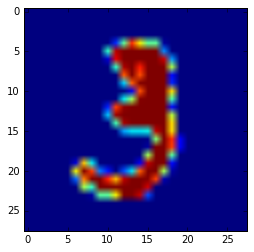

In [31]:
from matplotlib import pyplot as plt
%matplotlib inline
random_int = np.random.randint(0, 32)
image = features[random_int,:,:]
label = labels[random_int]
print "Label value: " + str(np.argmax(label))
print "One-hot-vector: " + str(label)
print "Batch shape: " + str(features.shape)
plt.imshow(image)
plt.show() 